## Configuration générale de l'environnement

In [1]:
from google.colab import drive
drive.mount('/content/drive')

wd = "/content/drive/MyDrive/manifold"

import os
# fixer le repertoire de travail
os.chdir(wd)
# Forcer UTF-8
os.environ['LC_ALL'] = 'C.UTF-8'
os.environ['LANG'] = 'C.UTF-8'

import locale
locale.getpreferredencoding = lambda: "UTF-8"

# Installation optuna ( recalcitrante par pip)
import subprocess
subprocess.run(['pip', 'install', 'optuna'])


# Lister les GPU disponibles et leurs carctéristiques
import tensorflow as tf

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"GPUs disponibles : {len(gpus)}")
    for i, gpu in enumerate(gpus):
        print(f"GPU {i}: {gpu}")
else:
    print("Aucun GPU disponible.")

for gpu in gpus:
    details = tf.config.experimental.get_device_details(gpu)
    print(details)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
GPUs disponibles : 1
GPU 0: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
{'compute_capability': (8, 0), 'device_name': 'NVIDIA A100-SXM4-40GB'}


In [2]:
# Bibilothèque "rapids" pour accélérer le calcul matriciel
!pip install\
    --extra-index-url=https://pypi.nvidia.com \
    cudf-cu12==24.10.* dask-cudf-cu12==24.10.* cuml-cu12==24.10.* \
    cugraph-cu12==24.10.* cuspatial-cu12==24.10.* cuproj-cu12==24.10.* \
    cuxfilter-cu12==24.10.* cucim-cu12==24.10.* pylibraft-cu12==24.10.* \
    raft-dask-cu12==24.10.* cuvs-cu12==24.10.* nx-cugraph-cu12==24.10.*

Looking in indexes: https://pypi.org/simple, https://pypi.nvidia.com


## Configuration locale en termes de librairies et d'outils

In [3]:
from sklearn.datasets import fetch_olivetti_faces
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import cupy as cp
import cuml
from cuml.linear_model import LogisticRegression as cuML_LogReg
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import fashion_mnist
import optuna
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, Dense, Flatten, Reshape, BatchNormalization, LeakyReLU, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.losses import MeanSquaredError
import json
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, Dense, Flatten, Reshape, BatchNormalization, LeakyReLU, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.losses import MeanSquaredError
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from tensorflow.keras.datasets import fashion_mnist




# Travail sur le dataset Fashion_mnist

---

## 1. Présentation du dataset

=== Aperçu du Dataset Fashion-MNIST ===
Nombre total d'exemples : 70000
Nombre total de caractéristiques (pixels) : 784
Dimensions des images : 28x28
Nombre de classes : 10

Exemples de classes :
[0 1 2 3 4 5 6 7 8 9]

=== Valeurs manquantes ===
Nombre total de valeurs manquantes : 0

=== Distribution des classes ===
Classe 0 : 7000 images
Classe 1 : 7000 images
Classe 2 : 7000 images
Classe 3 : 7000 images
Classe 4 : 7000 images
Classe 5 : 7000 images
Classe 6 : 7000 images
Classe 7 : 7000 images
Classe 8 : 7000 images
Classe 9 : 7000 images

=== Affichage de quelques exemples d'images ===


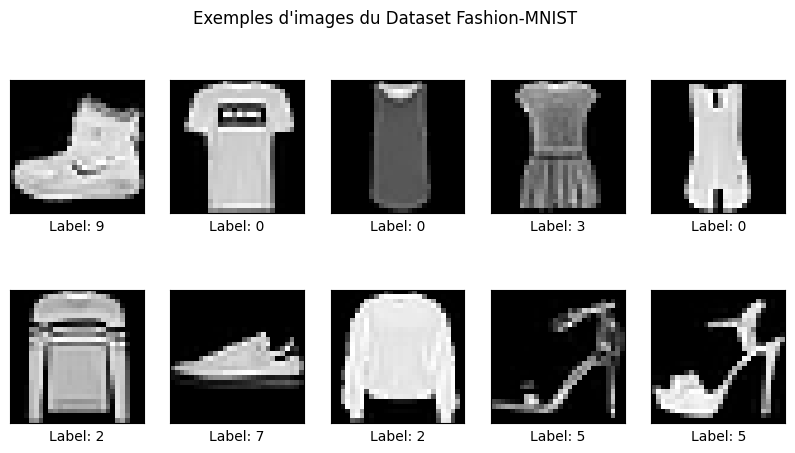

In [4]:
# Charger le dataset Fashion-MNIST
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

# Fusionner les ensembles train et test pour une vue d'ensemble
X = np.concatenate((X_train, X_test), axis=0)
y = np.concatenate((y_train, y_test), axis=0)

# Redimensionner les images
X_reshaped = X.reshape(X.shape[0], -1)

# Informations générales sur le dataset
def dataset_overview():
    print("=== Aperçu du Dataset Fashion-MNIST ===")
    print(f"Nombre total d'exemples : {X.shape[0]}")
    print(f"Nombre total de caractéristiques (pixels) : {X_reshaped.shape[1]}")
    print(f"Dimensions des images : {X.shape[1]}x{X.shape[2]}")
    print(f"Nombre de classes : {len(np.unique(y))}")
    print("\nExemples de classes :")
    print(np.unique(y))

# Vérification des valeurs manquantes
def check_missing_values():
    missing_values = np.isnan(X).sum()
    print(f"\n=== Valeurs manquantes ===")
    print(f"Nombre total de valeurs manquantes : {missing_values}")

# Distribution des classes
def class_distribution():
    unique, counts = np.unique(y, return_counts=True)
    class_dist = dict(zip(unique, counts))
    print("\n=== Distribution des classes ===")
    for key, value in class_dist.items():
        print(f"Classe {key} : {value} images")

# Affichage d'exemples d'images
def show_sample_images():
    print("\n=== Affichage de quelques exemples d'images ===")
    fig, ax = plt.subplots(2, 5, figsize=(10, 5))
    for i, axi in enumerate(ax.flat):
        axi.imshow(X[i], cmap='gray')
        axi.set(xticks=[], yticks=[], xlabel=f'Label: {y[i]}')
    plt.suptitle("Exemples d'images du Dataset Fashion-MNIST")
    plt.show()

# Fonction principale pour présenter le dataset à l'examinateur
def present_dataset():
    dataset_overview()
    check_missing_values()
    class_distribution()
    show_sample_images()

# Appeler la fonction pour présenter le dataset
present_dataset()


## 2. Calibrer les hyperparamètres

Nous nous servirons également de la librairie "Optuna"

In [5]:
def create_autoencoder(trial):
    # Hyperparamètres à optimiser
    num_filters_1 = trial.suggest_int('num_filters_1', 32, 128)
    num_filters_2 = trial.suggest_int('num_filters_2', 64, 256)
    latent_dim = trial.suggest_int('latent_dim', 32, 128)
    dropout_rate = trial.suggest_float('dropout_rate', 0.2, 0.5)
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)

    # Encodeur
    input_img = Input(shape=(28, 28, 1))
    x = Conv2D(num_filters_1, (3, 3), padding='same')(input_img)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    x = Conv2D(num_filters_2, (3, 3), padding='same', strides=(2, 2))(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    x = Flatten()(x)
    x = Dropout(dropout_rate)(x)
    encoded = Dense(latent_dim, activation='relu')(x)

    # Décodeur
    x = Dense(14 * 14 * num_filters_2, activation='relu')(encoded)
    x = Reshape((14, 14, num_filters_2))(x)
    x = Conv2DTranspose(num_filters_2, (3, 3), padding='same', strides=(2, 2))(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    x = Conv2DTranspose(num_filters_1, (3, 3), padding='same')(x)
    decoded = Conv2DTranspose(1, (3, 3), activation='sigmoid', padding='same')(x)

    autoencoder = Model(input_img, decoded)
    optimizer = Adam(learning_rate=learning_rate)
    autoencoder.compile(optimizer=optimizer, loss=MeanSquaredError())

    return autoencoder

def objective(trial):
    # Chargement des données
    (X_train, _), (X_test, _) = fashion_mnist.load_data()
    X_train = X_train.astype('float32') / 255.
    X_test = X_test.astype('float32') / 255.
    X_train = X_train.reshape((len(X_train), 28, 28, 1))
    X_test = X_test.reshape((len(X_test), 28, 28, 1))

    # Création du modèle
    model = create_autoencoder(trial)

    # Entraînement du modèle
    model.fit(X_train, X_train, epochs=5, batch_size=128, validation_data=(X_test, X_test), verbose=0)

    # Évaluation sur les données de test (perte MSE)
    loss = model.evaluate(X_test, X_test, verbose=0)
    return loss

# Création de l'étude Optuna
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

# Affichage des meilleurs hyperparamètres
print("Meilleurs hyperparamètres : ", study.best_params)


[I 2024-10-17 04:03:58,134] A new study created in memory with name: no-name-202bf9e5-1f75-4aba-8fad-63e0fa5629eb
<ipython-input-5-1922a6f824c9>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
[I 2024-10-17 04:04:48,772] Trial 0 finished with value: 0.007340984418988228 and parameters: {'num_filters_1': 34, 'num_filters_2': 149, 'latent_dim': 105, 'dropout_rate': 0.29800609960770413, 'learning_rate': 0.00017284628550570894}. Best is trial 0 with value: 0.007340984418988228.
[I 2024-10-17 04:05:38,009] Trial 1 finished with value: 0.005675836931914091 and parameters: {'num_filters_1': 128, 'num_filters_2': 152, 'latent_dim': 86, 'dropout_rate': 0.30440369334668504, 'learning_rate': 0.00012408247511553298}. Best is trial 1 with value: 0.005675836931914091.
[I 

Meilleurs hyperparamètres :  {'num_filters_1': 52, 'num_filters_2': 83, 'latent_dim': 126, 'dropout_rate': 0.367950390179366, 'learning_rate': 0.00027504282364666837}


In [6]:
# Récupérer Les meilleurs hyperparamètres
best_params = study.best_params
# Enregistrer les meilleurs hyperparamètres dans un fichier JSON dans ./results
import json
with open('./results/best_params_encoders_fashion_mnist.json', 'w') as f:
    json.dump(best_params, f)

In [7]:
# Charger les meilleurs hyperparamètres à partir du fichier JSON dans ./results
import json
with open('./results/best_params_encoders_fashion_mnist.json', 'r') as f:
    best_params = json.load(f)

# ( Ces étapes sont pour éviter de rejouer le calibrage si interruption de session)

## 3. Modèle Auto encoder avec les best_params évalués

In [8]:
# Fonction pour créer l'autoencodeur avec les hyperparamètres optimisés
def create_autoencoder_with_best_params(best_params):
    num_filters_1 = best_params['num_filters_1']
    num_filters_2 = best_params['num_filters_2']
    latent_dim = best_params['latent_dim']
    dropout_rate = best_params['dropout_rate']
    learning_rate = best_params['learning_rate']

    # Encodeur
    input_img = Input(shape=(28, 28, 1))
    x = Conv2D(num_filters_1, (3, 3), padding='same')(input_img)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    x = Conv2D(num_filters_2, (3, 3), padding='same', strides=(2, 2))(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    x = Flatten()(x)
    x = Dropout(dropout_rate)(x)
    encoded = Dense(latent_dim, activation='relu')(x)  # Espace latent

    # Décodeur
    x = Dense(14 * 14 * num_filters_2, activation='relu')(encoded)
    x = Reshape((14, 14, num_filters_2))(x)
    x = Conv2DTranspose(num_filters_2, (3, 3), padding='same', strides=(2, 2))(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    x = Conv2DTranspose(num_filters_1, (3, 3), padding='same')(x)
    decoded = Conv2DTranspose(1, (3, 3), activation='sigmoid', padding='same')(x)

    # Modèle autoencodeur complet
    autoencoder = Model(input_img, decoded)

    # Compilation du modèle
    optimizer = Adam(learning_rate=learning_rate)
    autoencoder.compile(optimizer=optimizer, loss=MeanSquaredError())

    # Renvoie à la fois l'autoencodeur complet et l'encodeur seul
    encoder = Model(input_img, encoded)  # Modèle de l'encodeur (pour espace latent)

    return autoencoder, encoder


In [9]:
# Chargement des données Fashion MNIST
(X_train, _), (X_test, _) = fashion_mnist.load_data()
X_train = X_train.astype('float32') / 255.
X_test = X_test.astype('float32') / 255.
X_train = X_train.reshape((len(X_train), 28, 28, 1))
X_test = X_test.reshape((len(X_test), 28, 28, 1))

# Création de l'autoencodeur et de l'encodeur
autoencoder, encoder = create_autoencoder_with_best_params(best_params)

# Entraînement de l'autoencodeur
autoencoder.fit(X_train, X_train, epochs=50, batch_size=128, validation_data=(X_test, X_test))

# Utilisation de l'encodeur pour obtenir les représentations dans l'espace latent
X_train_encoded = encoder.predict(X_train)
X_test_encoded = encoder.predict(X_test)

# Affichage des représentations encodées
print("Représentations encodées de X_train : ", X_train_encoded.shape)
print("Représentations encodées de X_test : ", X_test_encoded.shape)

Epoch 1/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - loss: 0.0298 - val_loss: 0.0296
Epoch 2/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0086 - val_loss: 0.0069
Epoch 3/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0070 - val_loss: 0.0067
Epoch 4/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0062 - val_loss: 0.0055
Epoch 5/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0056 - val_loss: 0.0052
Epoch 6/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0053 - val_loss: 0.0049
Epoch 7/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0050 - val_loss: 0.0047
Epoch 8/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0048 - val_loss: 0.0045
Epoch 9/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0046 - val_loss: 0.0045
Epoch 10/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0045 - val_loss: 0.0043
Epoch 11/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0044 - val_loss: 0.0041
Epoch 12/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/st

## 4. Evaluation de la qualité de la reduction de dimension obtenue

### 4.1 Visualistion de l'information (classes) avec t-sne 2d original vs réduit

#### En espace réduit:

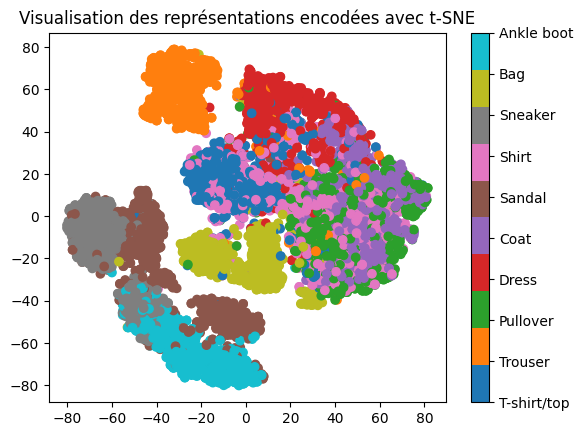

In [10]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

# Réduction de la dimension avec t-SNE pour visualisation
tsne = TSNE(n_components=2)
X_test_encoded_tsne = tsne.fit_transform(X_test_encoded)

# Nom des classes de Fashion MNIST
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# Plot des données encodées projetées dans un espace 2D
scatter = plt.scatter(X_test_encoded_tsne[:, 0], X_test_encoded_tsne[:, 1], c=_, cmap='tab10')

# Ajouter une barre de couleur avec les noms des classes
cbar = plt.colorbar(scatter, ticks=np.arange(10))  # Ajoute des ticks pour 10 classes
cbar.ax.set_yticklabels(class_names)  # Remplace les ticks par les noms des classes

# Ajouter un titre
plt.title("Visualisation des représentations encodées avec t-SNE")

# Afficher le plot
plt.show()


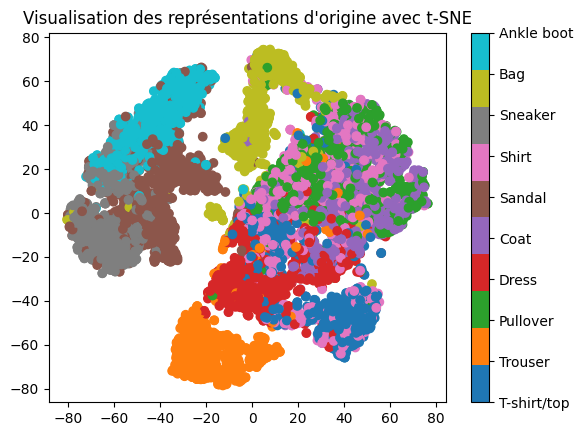

In [11]:
#### En espace d'origine
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


X_test_flat = X_test.reshape(-1, 28 * 28)

# Réduction de la dimension avec t-SNE pour visualisation
tsne = TSNE(n_components=2)
X_test_flat_tsne = tsne.fit_transform(X_test_flat)

# Nom des classes de Fashion MNIST
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


# Plot des données encodées projetées dans un espace 2D
scatter = plt.scatter(X_test_flat_tsne[:, 0], X_test_flat_tsne[:, 1], c=_, cmap='tab10')

# Ajouter une barre de couleur avec les noms des classes
cbar = plt.colorbar(scatter, ticks=np.arange(10))  # Ajoute des ticks pour 10 classes
cbar.ax.set_yticklabels(class_names)  # Remplace les ticks par les noms des classes

# Ajouter un titre
plt.title("Visualisation des représentations d'origine avec t-SNE")

# Afficher le plot
plt.show()

### 4.2 PCA : espace d'origine vs réduit

### Visualisation de l'information en espace réduit avec PCA 2d

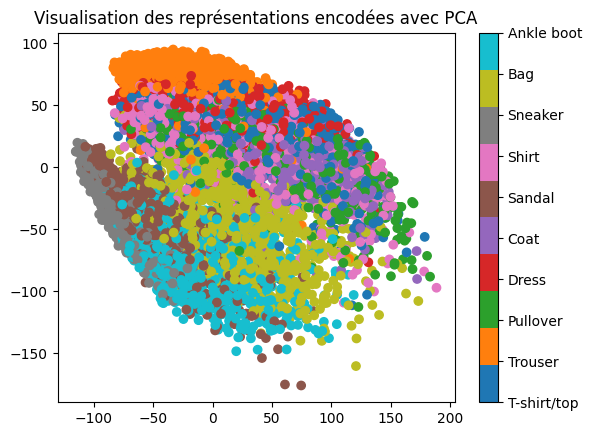

In [12]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

# Réduction de la dimension à 2 avec PCA pour visualisation
pca = PCA(n_components=2)
X_test_encoded_pca = pca.fit_transform(X_test_encoded)

# Nom des classes de Fashion MNIST
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# Utiliser les labels de Fashion MNIST (remplacer _ par y_test)
y_test_subset = _  # Exemple avec tous les labels de test

# Plot des données encodées projetées dans un espace 2D
scatter = plt.scatter(X_test_encoded_pca[:, 0], X_test_encoded_pca[:, 1], c=y_test_subset, cmap='tab10')

# Ajouter une barre de couleur avec les noms des classes
cbar = plt.colorbar(scatter, ticks=np.arange(10))  # Ajoute des ticks pour 10 classes
cbar.ax.set_yticklabels(class_names)  # Remplace les ticks par les noms des classes

# Ajouter un titre
plt.title("Visualisation des représentations encodées avec PCA")

# Afficher le plot
plt.show()


### En espace réduit en 3d

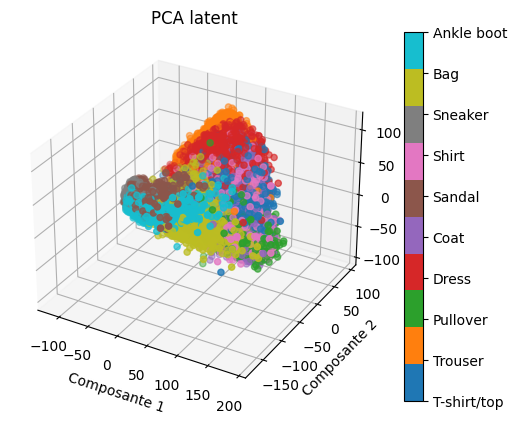

In [13]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # Import pour visualisation 3D
import numpy as np

# Réduction de la dimension à 3 avec PCA pour visualisation
pca = PCA(n_components=3)
X_test_encoded_pca_3d = pca.fit_transform(X_test_encoded)

# Nom des classes de Fashion MNIST
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# Utiliser les labels de Fashion MNIST (remplacer _ par y_test)
y_test_subset = _  # Remplacer par y_test si disponible

# Visualisation en 3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot des données encodées projetées dans un espace 3D
sc = ax.scatter(X_test_encoded_pca_3d[:, 0], X_test_encoded_pca_3d[:, 1], X_test_encoded_pca_3d[:, 2], c=y_test_subset, cmap='tab10')

# Ajouter une barre de couleur avec les noms des classes
cbar = plt.colorbar(sc, ticks=np.arange(10))  # Ajoute des ticks pour les 10 classes
cbar.ax.set_yticklabels(class_names)  # Remplace les ticks numériques par les noms des classes

# Ajouter les titres des axes
ax.set_xlabel('Composante 1')
ax.set_ylabel('Composante 2')
ax.set_zlabel('Composante 3')

# Ajouter un titre
ax.set_title("PCA latent")

# Afficher le graphe
plt.show()


### En espace d 'origine en 3d

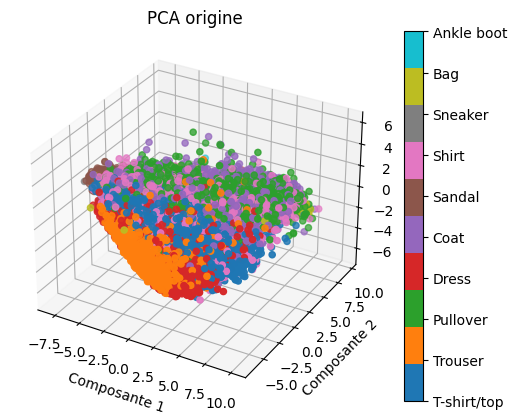

In [14]:


# Aplatir les images de 28x28 pixels en vecteurs de taille 784
X_test_flat = X_test.reshape(-1, 28*28)

# Réduction de la dimension à 3 avec PCA pour visualisation
pca = PCA(n_components=3)
X_test_pca_3d = pca.fit_transform(X_test_flat)

# Nom des classes de Fashion MNIST
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# Visualisation en 3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot des données brutes projetées dans un espace 3D avec PCA
sc = ax.scatter(X_test_pca_3d[:, 0], X_test_pca_3d[:, 1], X_test_pca_3d[:, 2], c=y_test, cmap='tab10')

# Ajouter une barre de couleur avec les noms des classes
cbar = plt.colorbar(sc, ticks=np.arange(10))  # Ajoute des ticks pour les 10 classes
cbar.ax.set_yticklabels(class_names)  # Remplace les ticks numériques par les noms des classes

# Ajouter les titres des axes
ax.set_xlabel('Composante 1')
ax.set_ylabel('Composante 2')
ax.set_zlabel('Composante 3')

# Ajouter un titre
ax.set_title("PCA origine")

# Afficher le graphe
plt.show()


313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
Erreur de reconstruction (MSE) : 0.0032753683626651764


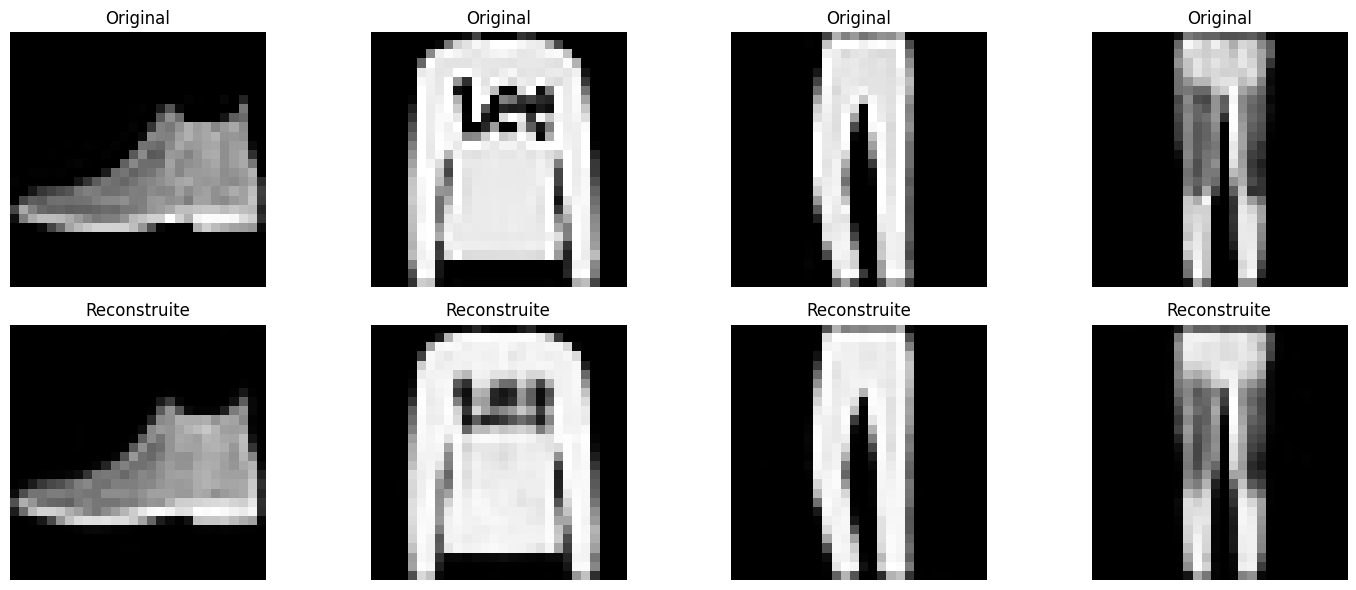

In [15]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# Prédire les reconstructions sur les données de test
X_test_reconstructed = autoencoder.predict(X_test)

# Calcul de l'erreur de reconstruction (MSE)
mse = mean_squared_error(X_test.flatten(), X_test_reconstructed.flatten())
print(f"Erreur de reconstruction (MSE) : {mse}")

# Nombre d'exemples à afficher
num_examples = 4

# Créer une figure pour afficher les images
fig, axes = plt.subplots(2, num_examples, figsize=(15, 6))

# Visualiser les images originales et reconstruites
for i in range(num_examples):
    # Afficher l'image originale
    axes[0, i].imshow(X_test[i].reshape(28, 28), cmap='gray')  # Adapter la forme si les images ne sont pas 28x28
    axes[0, i].axis('off')
    axes[0, i].set_title("Original")

    # Afficher l'image reconstruite
    axes[1, i].imshow(X_test_reconstructed[i].reshape(28, 28), cmap='gray')  # Adapter la forme si nécessaire
    axes[1, i].axis('off')
    axes[1, i].set_title("Reconstruite")

# Afficher les images
plt.tight_layout()
plt.show()


### Comparatif de prédiction sur l'espace latent et l'espace d'origine d'un mêm algo

Il s'agira ici de comparer la pertinence de l'information gardée, en essayant d'en extraire les labels avec le même algo : une regression logistique multinomiale

In [16]:
import numpy as np
import cupy as cp
from cuml import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler

# Aplatir les images de 28x28 en vecteurs de 784 dimensions pour l'espace d'origine
X_train_flat = X_train.reshape(-1, 28*28).astype(np.float32)
X_test_flat = X_test.reshape(-1, 28*28).astype(np.float32)

# Partie 1: Régression logistique sur l'espace d'origine (784 dimensions)
# Passer les données à cuML (GPU) en utilisant cupy
X_train_flat_gpu = cp.asarray(X_train_flat)
X_test_flat_gpu = cp.asarray(X_test_flat)
y_train_gpu = cp.asarray(y_train)
y_test_gpu = cp.asarray(y_test)

# Entraîner une régression logistique sur l'espace d'origine
logreg_origin = LogisticRegression(max_iter=500)
logreg_origin.fit(X_train_flat_gpu, y_train_gpu)

# Prédictions sur l'espace d'origine
y_pred_origin = logreg_origin.predict(X_test_flat_gpu)

# Calcul des métriques sur l'espace d'origine
accuracy_origin = accuracy_score(cp.asnumpy(y_test_gpu), cp.asnumpy(y_pred_origin))
precision_origin = precision_score(cp.asnumpy(y_test_gpu), cp.asnumpy(y_pred_origin), average='weighted')
recall_origin = recall_score(cp.asnumpy(y_test_gpu), cp.asnumpy(y_pred_origin), average='weighted')
f1_origin = f1_score(cp.asnumpy(y_test_gpu), cp.asnumpy(y_pred_origin), average='weighted')

# Partie 2: Régression logistique sur l'espace latent (réduit avec l'autoencodeur)
# Utiliser l'encodeur pour obtenir les représentations dans l'espace latent
X_train_encoded = encoder.predict(X_train)
X_test_encoded = encoder.predict(X_test)

# Normaliser les données de l'espace latent
scaler = StandardScaler()
X_train_encoded_scaled = scaler.fit_transform(X_train_encoded)
X_test_encoded_scaled = scaler.transform(X_test_encoded)

# Convertir en GPU arrays pour cuML
X_train_encoded_gpu = cp.asarray(X_train_encoded_scaled)
X_test_encoded_gpu = cp.asarray(X_test_encoded_scaled)

# Entraîner une régression logistique sur l'espace latent
logreg_latent = LogisticRegression(max_iter=500)  # Augmentation du nombre d'itérations
logreg_latent.fit(X_train_encoded_gpu, y_train_gpu)

# Prédictions sur l'espace latent
y_pred_latent = logreg_latent.predict(X_test_encoded_gpu)

# Calcul des métriques sur l'espace latent
accuracy_latent = accuracy_score(cp.asnumpy(y_test_gpu), cp.asnumpy(y_pred_latent))
precision_latent = precision_score(cp.asnumpy(y_test_gpu), cp.asnumpy(y_pred_latent), average='weighted')
recall_latent = recall_score(cp.asnumpy(y_test_gpu), cp.asnumpy(y_pred_latent), average='weighted')
f1_latent = f1_score(cp.asnumpy(y_test_gpu), cp.asnumpy(y_pred_latent), average='weighted')

# Récapitulatif des métriques
summary = {
    'Métrique': ['Accuracy', 'Precision', 'Recall', 'F1-Score'],
    'Origine': [accuracy_origin, precision_origin, recall_origin, f1_origin],
    'Latent': [accuracy_latent, precision_latent, recall_latent, f1_latent]
}

import pandas as pd
summary_df = pd.DataFrame(summary)

# Afficher le tableau récapitulatif
print(summary_df)


[W] [04:42:45.077536] L-BFGS: max iterations reached
[W] [04:42:45.078598] Maximum iterations reached before solver is converged. To increase model accuracy you can increase the number of iterations (max_iter) or improve the scaling of the input data.
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
[W] [04:42:49.461820] L-BFGS stopped, because the line search failed to advance (step delta = 0.000000)
    Métrique   Origine    Latent
0   Accuracy  0.842700  0.851700
1  Precision  0.841701  0.849965
2     Recall  0.842700  0.851700
3   F1-Score  0.841990  0.850608


## Pour tester : visualiser la representation abstraite des images en espace réduit

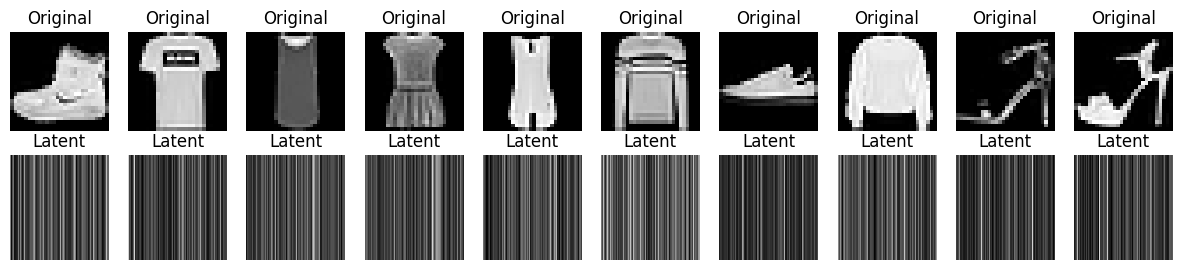

In [17]:
import matplotlib.pyplot as plt
import numpy as np

# Prenons les premières images encodées
num_images = 10  # Par exemple, afficher 10 images encodées

# Sélectionner les premières images encodées
encoded_images = X_train_encoded[:num_images]

# Affichage des images originales et des images encodées
fig, axes = plt.subplots(2, num_images, figsize=(15, 3))

for i in range(num_images):
    # Image originale (entrée du réseau)
    axes[0, i].imshow(X_train[i].reshape(28, 28), cmap='gray')
    axes[0, i].axis('off')
    axes[0, i].set_title('Original')

    # Image encodée (espace latent) - Représenter les valeurs en tant que vecteur aplati
    latent_image = encoded_images[i].reshape(1, -1)  # Aplatir les dimensions latentes
    axes[1, i].imshow(latent_image, cmap='gray', aspect='auto')
    axes[1, i].axis('off')
    axes[1, i].set_title('Latent')

plt.show()
